#corrective rag using wikipedia search

In [260]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [210]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.environ["HUGGINGFACE_API_KEY"]

In [211]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

In [212]:
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [213]:
embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [214]:
from langchain_community.document_loaders import TextLoader
loader=TextLoader('sample.txt')
docs=loader.load()
docs

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [215]:
document=RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=50).split_documents(docs)
document

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [216]:
vectordb=FAISS.from_documents(document,embedding)

In [217]:
db=vectordb.as_retriever()

In [218]:
ret_doc=db.get_relevant_documents("what is deep learning")

In [219]:
for doc in ret_doc:
    print(doc)

page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.

In a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.

Deep Learning - Geeksforgeeks
Scope of Deep Learning

Today Deep learning AI has become one of the most popular and visible areas of machin

In [220]:
prompt=ChatPromptTemplate.from_template(
    """
        Answer the following question based on the give context
        {context}

        question:{question}  
   """
)

In [221]:
chain=prompt|llm|StrOutputParser()

In [222]:
response=chain.invoke({"context":document,"question":"disadvanatge of deep learning"})

In [223]:
response

'Based on the provided text, the disadvantages of deep learning are:\n\n* **High computational requirements:** Deep learning models need significant computational resources (GPUs, TPUs) and large amounts of data for training and optimization.\n* **Requires large amounts of labeled data:**  Training often necessitates substantial labeled data, which can be expensive and time-consuming to obtain.\n* **Interpretability:** Deep learning models are complex ("black boxes"), making it difficult to understand how they arrive at their decisions.\n* **Overfitting:** Models can become overspecialized to training data, leading to poor performance on new data.\n* **Black-box nature:**  The inner workings are opaque, hindering understanding of how predictions are generated.'

In [224]:
from langgraph.graph import START,END,StateGraph
from typing import Annotated,TypedDict
import operator

In [225]:
class State(TypedDict):
    question:str
    generation:str
    websearch=str
    documents: Annotated[list[str],operator.add]

In [226]:
from pydantic import BaseModel,Field

In [227]:
class Check(BaseModel):
    binary_score:str=Field(description="check the document whether it is relevant to question and give binary score 'yes' or 'no'")

In [228]:
structured_output=llm.with_structured_output(Check)

In [229]:
system="""
          as You are grader assissting relavance of retrieved document to a user question
          if the document contain any keyword or semantic meaning related to the question
          give binary score of 'yes' or 'no' to indicate whether the document is 
          relavant the question
"""

prompt1=ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","retrieved document:\n {documents} and the question:/n {question}")
])

document_reader=prompt1|structured_output

In [230]:
question="what is deep learning"
answer=db.get_relevant_documents(question)
doc_text=answer[0].page_content
result=document_reader.invoke({"documents":doc_text,"question":question})

In [231]:
system1="""you are a question rewritter that converts an input question to a better version 
           that is optimized for web search     
"""

prompt2=ChatPromptTemplate.from_messages([
    ("system",system1),
    ("human","here is the initial question  :/n /n {question} formulate into improved question")
])

query_rewritter=prompt2|llm|StrOutputParser()

In [232]:
query_rewritter.invoke({"question":"give me about deep learning"})

'What are the fundamental concepts and formulations of deep learning?'

In [233]:
def retriever(state:State):

    print("==>document retriever <==")

    question=state["question"]
    documents=state["documents"]

    documents=db.get_relevant_documents(question)
    return {"documents":documents,"question":question}

In [234]:
def grade_decider(state:State):
     
    print("==> entering into grade decider <==")

    question=state["question"]
    documents=state["documents"]

    doclist=[]

    websearch="no"

    for d in documents:
        score=document_reader.invoke({"documents":d.page_content,"question":question})

        grade=score.binary_score

        if grade=='yes':
            print("===> document relevant <===")
            doclist.append(d)
        else:
            print("===> document not relevant <===")
            websearch='yes'
            continue
    
    return {"documents":doclist,"question":question,"websearch":websearch}


In [235]:
def rewrittering(state:State):

    print("===> question rewritting <===")
    
    question=state["question"]
    documents=state["documents"]

    betterquestion=query_rewritter.invoke({"question":question})
    return {"documents":documents,"question":betterquestion}

In [236]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

In [237]:
wiki=WikipediaAPIWrapper(top_k_results=3,doc_content_chars_max=250)
query=WikipediaQueryRun(api_wrapper=wiki,description="wikipedia search")

In [238]:
from langchain.schema import Document

In [239]:
def websearching(state:State):

    print("===> web search <===")

    question=state["question"]
    documents=state["documents"]

    result=query.invoke(question)
    web_result=Document(page_content=result)

    documents.append(web_result)
    return {"documents":documents,"question":question}


In [240]:
def generate_reponse(state:State):

    print("===> query is generating <===")

    question=state["question"]
    documents=state["documents"]

    genration=chain.invoke({"context":documents,"question":question})

    return {"question":question,"generation":genration} 


In [241]:
def decider(state:State):

    print("===> deciding tool <===")

    question=state["question"]
    documents=state["documents"]
    websearch=state["websearch"]

    if websearch=="yes":
        return "transform"
    else:
        return "generate_answer"

In [242]:
graph=StateGraph(State)

In [243]:
graph.add_node("retrieve",retriever)
graph.add_node("grade_decider",grade_decider)
graph.add_node("rewritter",rewrittering)
graph.add_node("websearch",websearching)
graph.add_node("generate",generate_reponse)
graph.add_conditional_edges("grade_decider",
                            decider,
                            {
                                "transform":"rewritter",
                                "generate_answer":"generate"

                            })
graph.set_entry_point("retrieve")
graph.add_edge("retrieve","grade_decider")
graph.add_edge("rewritter","websearch")
graph.add_edge("websearch","generate")
graph.add_edge("generate",END)

In [244]:
app=graph.compile()

In [245]:
from IPython.display import display,Image

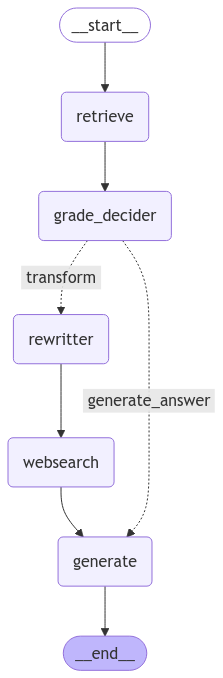

In [246]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [247]:
from pprint import pprint

In [248]:
question={"question":"what is deep learning"}

In [249]:
for answer in app.stream(question):
    for key,value in answer.items():
        pprint(f"node : {key}")
    pprint("/n.../n")
pprint(f"{value["generation"]}")

==>document retriever <==
'node : retrieve'
'/n.../n'
==> entering into grade decider <==
===> document relevant <===
===> document relevant <===
===> document relevant <===
===> document relevant <===
===> deciding tool <===
'node : grade_decider'
'/n.../n'
===> query is generating <===
'node : generate'
'/n.../n'
('Deep learning is a branch of machine learning based on artificial neural '
 'network architecture.  An artificial neural network (ANN) uses layers of '
 'interconnected nodes (neurons) that process and learn from input data.  In a '
 'fully connected deep neural network, data flows through an input layer and '
 "one or more hidden layers, with each neuron's output becoming the input for "
 'neurons in the next layer.  This series of nonlinear transformations allows '
 'the network to learn complex representations of the input data.  Deep '
 'learning excels at complex tasks like image processing and natural language '
 'processing.')


In [250]:
question2={"question":"what is taj mahal"}

In [252]:
for answer in app.stream(question2):
    for key,value in answer.items():
        pprint(f"node : {key}")
    pprint("/n.../n")
pprint(f"{value["generation"]}")

==>document retriever <==
'node : retrieve'
'/n.../n'
==> entering into grade decider <==
===> document not relevant <===
===> document not relevant <===
===> document not relevant <===
===> document not relevant <===
===> deciding tool <===
'node : grade_decider'
'/n.../n'
===> question rewritting <===
'node : rewritter'
'/n.../n'
===> web search <===
'node : websearch'
'/n.../n'
===> query is generating <===
'node : generate'
'/n.../n'
('The Taj Mahal is an ivory-white marble mausoleum located on the right bank '
 'of the Yamuna River in Agra, Uttar Pradesh, India.  It was commissioned in '
 '1631.')


In [258]:
def pattern(n):
    for i in range(n):
        print("*"*i)

In [259]:
pattern(5)


*
**
***
****
